In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from utils import generate_data
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
plt.rcParams["figure.figsize"] = (12,6)
import warnings
from timeit import default_timer as timer

In [2]:
data = generate_data()

In [3]:
data.x_df.head()
# days since start is z normalized

,intercept,days_since_start,days_since_start_squared,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,seasonality_cos,seasonality_sin
0,1.0,-1.729679,2.228932,0,0,0,0,0,1,0.999852,0.017213
1,1.0,-1.726517,2.216707,0,0,0,0,0,0,0.999407,0.034422
2,1.0,-1.723355,2.204505,1,0,0,0,0,0,0.998667,0.051620
3,1.0,-1.720193,2.192325,0,1,0,0,0,0,0.997630,0.068802
4,1.0,-1.717031,2.180168,0,0,1,0,0,0,0.996298,0.085965


In [4]:
gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
gpois_res = gpois_mdl.fit(method="ncg")

Optimization terminated successfully.
         Current function value: 5.996685
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 7


In [5]:
gpois_res.params

intercept                   5.276758
days_since_start            0.361330
days_since_start_squared   -0.130866
day_of_week_1               0.172064
day_of_week_2               0.135735
day_of_week_3               0.244916
day_of_week_4               0.240074
day_of_week_5               0.106098
day_of_week_6              -0.042821
seasonality_cos             0.178063
seasonality_sin            -0.065844
alpha                       6.937267
dtype: float64

In [6]:
print(gpois_res.summary2())

                       Results: GeneralizedPoisson
Model:                 GeneralizedPoisson  Pseudo R-squared:  0.053      
Dependent Variable:    y                   AIC:               13156.7395 
Date:                  2022-04-04 11:36    BIC:               13216.7216 
No. Observations:      1095                Log-Likelihood:    -6566.4    
Df Model:              10                  LL-Null:           -6932.6    
Df Residuals:          1084                LLR p-value:       6.7056e-151
Converged:             1.0000              Scale:             1.0000     
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
intercept                 5.2768   0.0377 139.9581 0.0000  5.2029  5.3507
days_since_start          0.3613   0.0149  24.2026 0.0000  0.3321  0.3906
days_since_start_squared -0.1309   0.0137  -9.5430 0.0000 -0.

In [7]:
# Marginal effects
me = gpois_res.get_margeff(method='dydx')
me.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
 GeneralizedPoisson Marginal Effects 
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
============================================================================================
                              dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
days_since_start            86.7803      3.829     22.665      0.000      79.276      94.285
days_since_start_squared   -31.4301      3.329     -9.441      0.000     -37.955     -24.905
day_of_week_1               41.3244     11.992      3.446      0.001      17.820      64.828
day_of_week_2               32.5994     12.069      2.701      0.007       8.945      56.254
day_of_week_3               58.8213     11.883      4.950      0.000      35.531      82.111
day_of_week_4               57.6582     11.896      4.847      0.000      34.343      80.973
day_of_week_5               25.4815     12.132      2.100      0.036       1.704      49.259
day_of_week_6              -10.2843     12.400     -0.829      0.407     -34.588      14.019
seasonality_cos             42.7651      4.560      9.378      0.000      33.827      51.703
seasonality_sin            -15.8136      4.698     -3.366      0.001     -25.021      -6.606
============================================================================================
"""

## Extend Generic Likelihood Model

In [8]:
eps = 0. #to fix log(0) error
def _ll_latentnorm(y, X, beta, alph):
    mu = (np.dot(X, beta)) # Should we exponentiate this??
    sigma = np.exp(np.dot(X, alph))
    Phi_bar = stats.norm(mu, sigma).cdf(np.log1p(y))
    Phi_underbar = stats.norm(mu, sigma).cdf(np.log(y))
    ll = np.log(Phi_bar - Phi_underbar + eps)
    #print(Phi_bar - Phi_underbar)
    return ll

def _gradutils(y, X, beta, alph):
    mu = (np.dot(X, beta)) # Should we exponentiate this??
    sigma = np.exp(np.dot(X, alph))

    z_bar = (np.log1p(y) - mu) / sigma 
    z_underbar = (np.log(y) - mu) / sigma

    Phi_bar = stats.norm.cdf(z_bar)
    Phi_underbar = stats.norm.cdf(z_underbar)
    Phi  = Phi_bar - Phi_underbar + eps #small tolerance to fix div/zero error

    phi_bar = stats.norm.pdf(z_bar)
    phi_underbar = stats.norm.pdf(z_underbar)
    phi = phi_bar - phi_underbar + eps #small tolerance
    
    kappa_0 = phi / Phi
    kappa_1 = (z_bar * phi_bar - z_underbar * phi_underbar) / Phi
    kappa_2 = (z_bar**2 * phi_bar - z_underbar**2 * phi_underbar) / Phi
    kappa_3 = (z_bar**3 * phi_bar - z_underbar**3 * phi_underbar) / Phi
    
    return kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma
    
def _vec_matrix_multiply(a, B):
    return np.apply_along_axis(lambda x: x * a, 0, B)

In [9]:
class MyLatentNormal(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(MyLatentNormal, self).__init__(endog, exog, **kwds)
        self.nparams = 22
        
    def nloglikeobs(self, params):
        exog = self.exog
        endog = self.endog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        ll = _ll_latentnorm(endog, exog, beta, alph)
        params_alt = params.copy()
        params_alt[0] = 0.
#         params_alt[11] = 0.
        return -ll - self.penalty*np.sum(params_alt**2)/self.endog.size
    
    def score(self, params):
        y = self.endog
        X = self.exog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        
        kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma = _gradutils(y, X, beta, alph)
        
        beta_alt = beta.copy()
        beta_alt[0] = 0
        alph_alt = alph.copy()
#         alph_alt[0] = 0.
        
        grad_beta = -(kappa_0 / sigma) @ X - self.penalty*2 * beta_alt
        grad_alph = -kappa_1 @ X - self.penalty*2 * alph_alt
        
        return np.append(grad_beta, grad_alph)
    
    def hessian(self, params):
        y = self.endog
        X = self.exog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        
        kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma = _gradutils(y, X, beta, alph)
        
        #xx = np.einsum('ij,ij-> i', X, X) # row-wise dot product?
        k_beta = (kappa_0**2 + kappa_1) / sigma**2
        k_alph = kappa_1 * (kappa_1 - 1) + kappa_3
        k_beta_alph = (kappa_2 + kappa_0*(kappa_1 - 1)) / sigma
        H_beta = np.zeros([11, 11])
        H_alph = np.zeros([11, 11])
        H_beta_alph = np.zeros([11, 11])
                  
        for i in range(X.shape[0]):
            x = X[i]
            xxT = np.outer(x, x)
            H_beta -= k_beta[i] * xxT
            H_alph -= k_alph[i] * xxT
            H_beta_alph -= k_beta_alph[i] * xxT
        
        H_all = np.block([[H_beta, H_beta_alph], [H_beta_alph.T, H_alph]]) # 22 x 22
        penalty_matrix = self.penalty*2 * np.eye(22)
        penalty_matrix[0, 0] = 0.
#         penalty_matrix[11, 11] = 0.

        return H_all - penalty_matrix
    
    def predict(self, params, exog=None, n=1000):
        if exog is None:
            X = self.exog
        else:
            X = exog
            
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        mu = (np.dot(X, beta))
        sigma = np.exp(np.dot(X, alph))
        Z = stats.norm(mu,sigma).rvs(size = (n, self.endog.size)) # n random realizations. Could find closed form..
        Y_hat = np.floor(np.exp(Z)).mean(axis=0)
        return Y_hat
    
    def mse(self):
        r = self.endog - self.predict()
        return np.mean(r**2)
        
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, penalty=0., **kwds):
        self.penalty = penalty
        #print(self.penalty)
        if start_params is None:
            # Reasonable starting values
            start_params = np.zeros(self.nparams)
            start_params[0] = np.log(np.mean(self.endog)) # beta
        return super(MyLatentNormal, self).fit(start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)
    

def fittedmean(res):
    return pd.Series(res.exog @ res.params[:11])

def fittedvar(res):
    return pd.Series(np.exp(res.exog @ res.params[11:]))

def mse(yhat, y):
    r = y - yhat
    return np.mean(r**2)

In [10]:
names = list(data.x_df)
names_alpha = [s + "_alpha" for s in names]

In [11]:
np.seterr(divide = 'warn')
np.seterr(invalid= 'warn')

start_params = 0. * np.ones(22)
start_params[:11] = gpois_res.params[:11]
mod = MyLatentNormal(data.y, data.x_df, extra_params_names=names_alpha)

mod_res = mod.fit(method = "ncg", start_params = start_params, maxiter=100, penalty=1e-4)
print(mod_res.summary())
print(f"True Beta: {data.beta}")
print(f"True Alpha: {data.alpha}")

Optimization terminated successfully.
         Current function value: 5.911693
         Iterations: 12
         Function evaluations: 19
         Gradient evaluations: 17
         Hessian evaluations: 12
                            MyLatentNormal Results                            
Dep. Variable:                      y   Log-Likelihood:                -6473.3
Model:                 MyLatentNormal   AIC:                         1.297e+04
Method:            Maximum Likelihood   BIC:                         1.302e+04
Date:                Mon, 04 Apr 2022                                         
Time:                        11:36:21                                         
No. Observations:                1095                                         
Df Residuals:                    1084                                         
Df Model:                          10                                         
                                     coef    std err          z      P>|z|      [0.0

<ipython-input-8-085365bf748d>:7: RuntimeWarning: divide by zero encountered in log
  ll = np.log(Phi_bar - Phi_underbar + eps)
<ipython-input-8-085365bf748d>:26: RuntimeWarning: divide by zero encountered in true_divide
  kappa_0 = phi / Phi
<ipython-input-8-085365bf748d>:26: RuntimeWarning: invalid value encountered in true_divide
  kappa_0 = phi / Phi
<ipython-input-8-085365bf748d>:27: RuntimeWarning: divide by zero encountered in true_divide
  kappa_1 = (z_bar * phi_bar - z_underbar * phi_underbar) / Phi
<ipython-input-8-085365bf748d>:27: RuntimeWarning: invalid value encountered in true_divide
  kappa_1 = (z_bar * phi_bar - z_underbar * phi_underbar) / Phi
<ipython-input-8-085365bf748d>:28: RuntimeWarning: divide by zero encountered in true_divide
  kappa_2 = (z_bar**2 * phi_bar - z_underbar**2 * phi_underbar) / Phi
<ipython-input-8-085365bf748d>:28: RuntimeWarning: invalid value encountered in true_divide
  kappa_2 = (z_bar**2 * phi_bar - z_underbar**2 * phi_underbar) / Phi
<ipyt

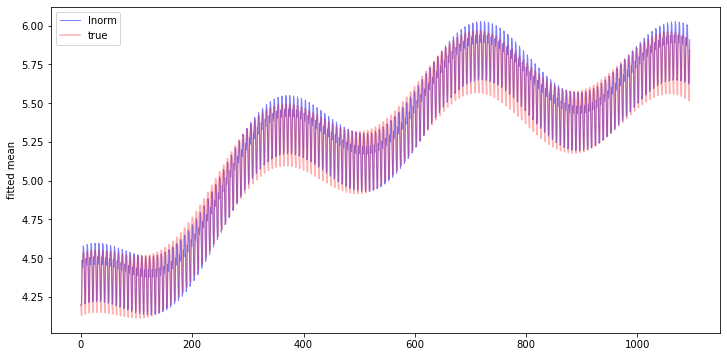

In [12]:
fittedmean(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.mu, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

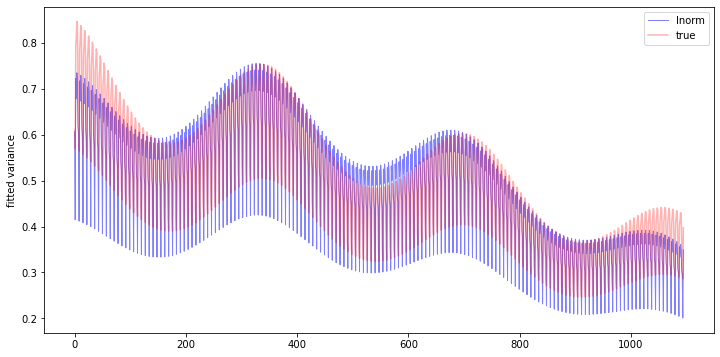

In [13]:
fittedvar(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.sigma, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted variance")
plt.show()

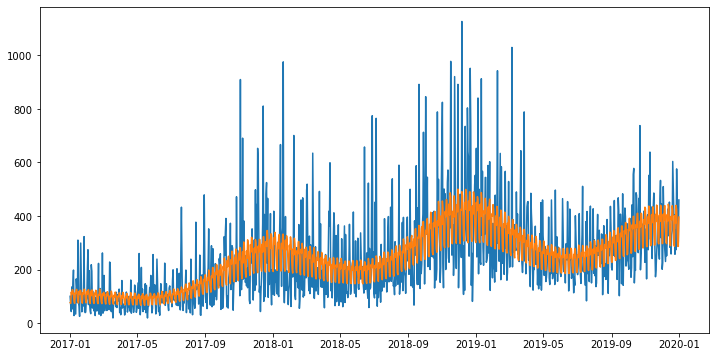

In [14]:
Y_hat = mod_res.predict(n=1000)
plt.plot(data.days, data.y)
plt.plot(data.days, Y_hat)
plt.show()

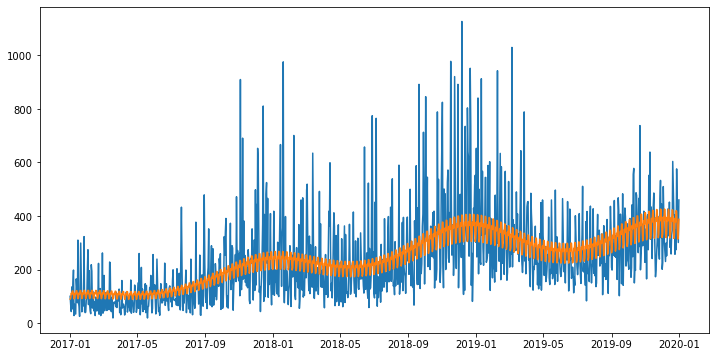

In [15]:
plt.plot(data.days, data.y)
plt.plot(data.days, gpois_res.predict())
plt.show()

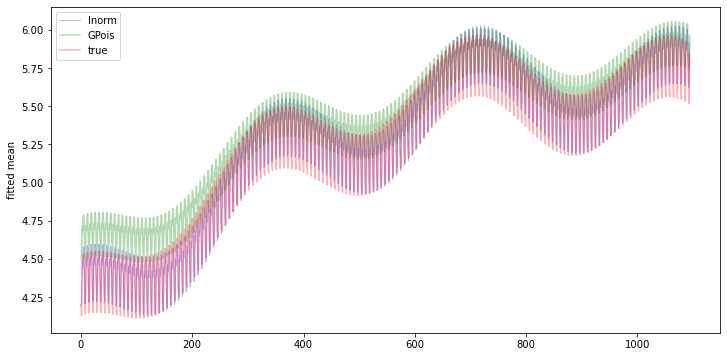

In [16]:
fittedmean(mod_res).plot(alpha = 0.3, color = "blue", linewidth = 1, label = "lnorm")
gpois_res.fittedvalues.plot(alpha = 0.3, color = "green", label = "GPois")
plt.plot(data.mu, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

In [17]:
# Negative Hessian is PD at optimal values
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, -1., -0.2, -0.03, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.16, -0.05])
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
np.linalg.eigvals(-mod.hessian(starting_vals))

array([1235.74435327, 1168.99963091, 1107.16724286,  829.86607559,
        660.616976  ,  539.06134503,  482.68630404,  310.412126  ,
        278.12116058,    4.41038664,   19.98222301,  226.81049411,
         70.92010908,   74.28022859,   83.94964417,   94.67779009,
         93.79974832,  160.81228907,  152.23594374,  157.54301676,
        155.49351473,  155.80830749])

In [18]:
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     bs = mod_res.bootstrap(nrep=1, method="ncg", store = 0, disp = 0) # we can bootstrap SE

In [19]:
# bs[0] #mean estimates

## Simulation 

In [20]:
# What else should we test?
N = 50
penalty = 1e-4
sim_params = list()
sim_mse = list()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(N):
        data = generate_data()
        
        pois_mdl = sm.Poisson(data.y, data.x_df)
        pois_res = pois_mdl.fit(disp=0)
        sim_params.append(["pois"] + pois_res.params[:11].tolist())
        
        gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
        gpois_res = gpois_mdl.fit(disp=0)
        sim_params.append(["gpois"]+ gpois_res.params[:11].tolist())
        
        NB1_mdl = sm.NegativeBinomialP(data.y, data.x_df,p=1)
        NB1_res = NB1_mdl.fit(disp=0)
        sim_params.append(["NB1"]+ NB1_res.params[:11].tolist())
        
        mod = MyLatentNormal(data.y, data.x_df, extra_params_names=names_alpha)
        start_params = np.zeros(22)
        start_params[:11] = pois_res.params
        mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        sim_params.append(["lnorm"] + mod_res.params[:11].tolist()) # Just the model coeffecients

        data = generate_data() #new data
        Xnew = data.x_df
        # out of sample prediction MSE
        sim_mse.append([mse(mod_res.predict(exog=Xnew), data.y), mse(pois_res.predict(exog=Xnew), data.y), 
                        mse(gpois_res.predict(exog=Xnew), data.y), mse(NB1_res.predict(exog=Xnew), data.y)])


In [21]:
sim_params = pd.DataFrame(sim_params, columns=["model"] + data.x_df.columns.to_list())

In [22]:
sim_params.groupby(by = "model").mean().T

model,NB1,gpois,lnorm,pois
intercept,5.173935,5.218958,4.995778,5.070929
days_since_start,0.347532,0.356667,0.402723,0.350483
days_since_start_squared,-0.144240,-0.134085,-0.172342,-0.174452
day_of_week_1,0.291074,0.241465,0.330943,0.392683
day_of_week_2,0.325445,0.268305,0.367167,0.441359
day_of_week_3,0.368264,0.303139,0.414623,0.498427
day_of_week_4,0.346479,0.281245,0.389918,0.477930
day_of_week_5,0.227627,0.189799,0.258896,0.306594
day_of_week_6,0.065828,0.055100,0.078688,0.089937
seasonality_cos,0.179059,0.147365,0.197360,0.239498


In [23]:
#MSE
pd.DataFrame(sim_mse, columns=["lnorm", "pois", "gpois", "NB1"]).describe()

,lnorm,pois,gpois,NB1
count,50.000000,50.000000,50.000000,50.000000
mean,20216.241195,20247.189872,20768.207692,20418.499891
std,2589.794908,2601.999431,2812.825012,2744.553647
min,15690.417296,15655.003335,15875.057984,15638.664461
25%,18280.811745,18125.287962,18467.828607,18179.486629
50%,20181.448158,20142.503710,20691.850326,20349.109397
75%,22181.920355,22005.618837,23032.262106,22556.761116
max,25341.752685,25511.944546,26470.325268,25959.532419


In [24]:
N = 50
sim_solver_times = list()
sim_solver_fcalls = list()
penalty = 1e-4

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(N):
        data = generate_data()
        fcalls = []
        
        # Seed with poisson parameters
        pois_mdl = sm.Poisson(data.y, data.x_df)
        pois_res = pois_mdl.fit(disp=0)
        start_params = np.zeros(22)
        start_params[:11] = pois_res.params
        
        mod = MyLatentNormal(data.y, data.x_df, extra_params_names=names_alpha)
        
        start = timer()
        mod_res = mod.fit(method = "ncg", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        ncg = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "cg", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        cg = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        bfgs = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "powell", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        powell = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        sim_solver_times.append([ncg, cg, bfgs, powell])
        sim_solver_fcalls.append(fcalls)

In [25]:
pd.DataFrame(sim_solver_times, columns=["ncg", "cg", "bfgs", "powell"]).describe()

,ncg,cg,bfgs,powell
count,50.000000,50.000000,50.000000,50.000000
mean,0.159706,0.216952,0.053804,1.143039
std,0.014771,0.031834,0.001624,0.088357
min,0.141991,0.156191,0.050838,1.078620
25%,0.151618,0.195800,0.053113,1.092465
50%,0.158327,0.214454,0.053533,1.105567
75%,0.161708,0.239499,0.054594,1.136378
max,0.240876,0.293274,0.058770,1.377619


In [26]:
pd.DataFrame(sim_solver_fcalls, columns=["ncg", "cg", "bfgs", "powell"]).describe()

,ncg,cg,bfgs,powell
count,50.000000,50.000000,50.000000,50.000000
mean,16.440000,130.860000,26.720000,1181.960000
std,7.429011,18.835496,0.572855,82.615401
min,13.000000,94.000000,26.000000,1142.000000
25%,14.000000,118.250000,26.000000,1146.250000
50%,15.000000,129.500000,27.000000,1150.000000
75%,17.000000,144.750000,27.000000,1153.000000
max,67.000000,162.000000,28.000000,1392.000000
